# V1 - Messy Code for non-adversarially trained Deep Model

# 0. Initialisation

In [ ]:

import json
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from torch import Tensor
from torch.nn import Module, Linear, Conv1d, MaxPool1d, ReLU, LSTM, CrossEntropyLoss, functional as F, Sequential, Embedding
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader, TensorDataset, Subset, WeightedRandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score
import wandb

WANDB_ENTITY = 'my_wandb_entity' # Sensitive - replaced with generic values
WANDB_PROJECT = 'my_wandb_project' # Sensitive - replaced with generic values

MY_SEED = 6

torch.manual_seed(MY_SEED)


def get_X_signal(df_signal):
    X = np.zeros((len(df_signal), 160, 3)) # Initialise
    for i in range(len(df_signal)):
        X[i, :, :] = np.array([
            df_signal['x'].iloc[i], 
            df_signal['y'].iloc[i], 
            df_signal['z'].iloc[i], 
        ]).transpose()
    X = np.array(X, dtype = np.float32)
    return torch.tensor(X)


def plot_signal(row, title = None, test = False, seperate_ax = False):
    if seperate_ax:
        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10), layout = 'constrained')
        axs.ravel()
        for ax, c in zip(axs, ['x', 'y', 'z']):
            y = row[c]
            ax.plot(y, label = c)
        plt.legend(bbox_to_anchor = [1, 1])
        if title is None:
            if not test:
                title = row['id'] + ': ' + row['activity']
            else:
                title = row['id']
        plt.suptitle(title)
        plt.show()
    else:
        fig, ax = plt.subplots(figsize = (13, 3), layout = 'constrained')
            
        for c in ['x', 'y', 'z']:
            y = row[c]
            ax.plot(y, label = c)
        plt.legend(bbox_to_anchor = [1, 1])
        if title is None:
            if not test:
                title = row['id'] + ': ' + row['activity']
            else:
                title = row['id']
        plt.suptitle(title)
        plt.show()
        
        
def get_mean_std(X: Tensor, dims = (0, 1)) -> tuple:
    return X.mean(dim = dims), X.std(dim = dims)


def normalize_X(X: Tensor, mean_std: tuple = None, dims = (0, 1)) -> Tensor:
    if mean_std == (None, None):
        return X
    if mean_std is None:
        mean_std = get_mean_std(X, dims = dims)
    
    return (X - mean_std[0]) / mean_std[1]



df_train = pd.read_csv('../data/processed/train_signal_clean.csv', converters={'x': json.loads, 'y': json.loads, 'z': json.loads})
df_test = pd.read_csv('../data/processed/test_signal_clean.csv', converters={'x': json.loads, 'y': json.loads, 'z': json.loads})

X_train = get_X_signal(df_train)
X_test = get_X_signal(df_test) 

scale_mean, scale_std = get_mean_std(X_train)

labels_train = df_train['activity']
le = LabelEncoder()
y_train = Tensor(le.fit_transform(labels_train)).long()
NUM_CLASSES = len(le.classes_)
class_counts = np.bincount(y_train, minlength=NUM_CLASSES)
class_weights = 1.0 / class_counts
class_weights = class_weights * (len(y_train) / np.sum(class_weights*class_counts))
class_weights = torch.tensor(class_weights, dtype = torch.float32)

def extract_model_config(model: Module):
    config = {}
    for name, module in model.named_modules():
        if name == "":
            continue  # skip the top-level module itself

        layer_type = type(module).__name__
        layer_config = {"type": layer_type}

        if isinstance(module, Conv1d):
            layer_config.update({
                "in_channels": module.in_channels,
                "out_channels": module.out_channels,
                "kernel_size": module.kernel_size,
                "padding": module.padding,
            })
        elif isinstance(module, Linear):
            layer_config.update({
                "in_features": module.in_features,
                "out_features": module.out_features,
            })
        elif isinstance(module, LSTM):
            layer_config.update({
                "input_size": module.input_size,
                "hidden_size": module.hidden_size,
                "num_layers": module.num_layers,
                "bidirectional": module.bidirectional,
            })
        elif isinstance(module, MaxPool1d):
            layer_config.update({
                "kernel_size": module.kernel_size,
                "stride": module.stride,
            })

        config[name] = layer_config

    return config


def wandb_config_entry(model: Module, name: str, train_params: dict, entity: str, project: str) -> wandb.init:
    config = {}
    config['architecture'] = extract_model_config(model)
    config['training'] = train_params
    return wandb.init(name = name, project = project, entity = entity, config = config)


def train_test_datasets(X, y, train_proportion, batch_size, normalize):
    sss = StratifiedShuffleSplit(n_splits= 1, train_size = train_proportion, random_state=MY_SEED)
    indices = np.arange(len(y))
    train_idx, val_idx = next(sss.split(indices, y.numpy()))
    
    dataset = TensorDataset(X, y)
    
    # train_size = int(train_proportion * len(dataset))
    # val_size = len(dataset) - train_size

    # train_dataset, val_dataset = random_split(dataset=dataset, lengths = [train_size, val_size])
    train_dataset, val_dataset = Subset(dataset, train_idx), Subset(dataset, val_idx)
    if normalize:
        mean, scale = get_mean_std(train_dataset[:][0])
        train_X = normalize_X(train_dataset[:][0], (mean, scale))
        val_X = normalize_X(val_dataset[:][0], (mean, scale))
        train_dataset = TensorDataset(train_X, train_dataset[:][1])
        val_dataset = TensorDataset(val_X, val_dataset[:][1])
    else:
        mean, scale = None, None
        
    y_train_split = y[train_idx]
    sampler_weights = class_weights[y_train_split.numpy()]
    sampler = WeightedRandomSampler(sampler_weights, num_samples = len(sampler_weights))
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, sampler = sampler)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
    return train_loader, train_dataset, val_dataset, val_loader, mean, scale


def new_model_run(model: Module, name: str, train_params: dict, entity = WANDB_ENTITY, project=WANDB_PROJECT, X=X_train, y=y_train, optimizer_class = RMSprop, loss_fn = CrossEntropyLoss(weight = class_weights), show_conf_matrix = False, normalize = False, alpha = 0):    
    run = wandb_config_entry(model, name, train_params, entity, project)
    train_proportion = train_params['train_proportion']
    batch_size = train_params['batch_size']
    lr = train_params['lr']
    num_epochs = train_params['num_epochs']

    optimizer = optimizer_class(params = model.parameters(), lr = lr, weight_decay = alpha)
    
    train_loader, train_dataset, val_dataset, val_loader, mean, scale = train_test_datasets(X, y, train_proportion, batch_size, normalize = normalize)
    model.train()

    X_val, y_val = val_dataset[:]

    for epoch in range(num_epochs):
        t = time.time()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val)
            _, predicted = torch.max(val_outputs, 1)
            accuracy = (predicted == y_val).float().mean().item()
        predicted_np = predicted.cpu().numpy()
        y_val_np = y_val.cpu().numpy()

        precision = precision_score(y_val_np, predicted_np, average='weighted')
        recall = recall_score(y_val_np, predicted_np, average='weighted')
        f1 = f1_score(y_val_np, predicted_np, average='weighted')
        epoch_time = time.time() - t
        run.log({
            'epoch': epoch,
            'train_loss': loss.item(),
            'val_loss': val_loss.item(),
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'epoch_time': epoch_time
        })
        print(f"Epoch {epoch}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}, Accuracy = {accuracy}")
        print(f"Epoch {epoch}: Precision = {precision}, Recall = {recall}, F1 Score = {f1}")
    run.finish()
    
    if show_conf_matrix:
        conf_matrix(model, val_loader)
    return mean, scale
    
def conf_matrix(model, val_loader):
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch
            y_batch = y_batch

            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(cm)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 1. Construct Model

In [39]:
normalize = False
bidirectional = True
num_filters = 40
num_layers = 2
alpha = 0.005
class MyModel(Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLU()
        self.conv1 = Conv1d(in_channels=3, out_channels = num_filters, kernel_size=5, padding = 'same')
        self.conv2 = Conv1d(in_channels=num_filters, out_channels = num_filters, kernel_size=7, padding = 'same')
        self.conv3 = Conv1d(in_channels=num_filters, out_channels = num_filters, kernel_size=9, padding = 'valid', stride = 2)
        self.conv4 = Conv1d(in_channels=num_filters, out_channels = num_filters, kernel_size=11, padding = 'valid', stride = 3)
        self.lstm1 = LSTM(num_filters, hidden_size=num_filters, batch_first=True, dropout = 0.5, num_layers=num_layers, bidirectional= bidirectional)
        self.fc = Linear(num_filters * num_layers * (2 if bidirectional else 1), NUM_CLASSES)
        
    def forward(self, x: Tensor):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x) 
        x = x.permute(0, 2, 1) 
        avg_pool = torch.mean(x, dim=2)  
        max_pool, _ = torch.max(x, dim=2)
        x = torch.cat((avg_pool, max_pool), dim=1) 
        x = self.fc(x)
        return x

In [40]:
train_params = {
    'train_proportion': 0.8,
    'batch_size': 32,
    'lr': 0.001,
    'num_epochs': 15
}

# Training & Assessment

/opt/anaconda3/lib/python3.12/site-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: Training Loss = 0.5317050814628601, Validation Loss = 0.881819486618042, Accuracy = 0.4177018702030182
Epoch 0: Precision = 0.4828201111558021, Recall = 0.41770186335403725, F1 Score = 0.40092043515913856


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Training Loss = 0.541565477848053, Validation Loss = 0.7793411016464233, Accuracy = 0.5046584010124207
Epoch 1: Precision = 0.4658849323409495, Recall = 0.5046583850931677, F1 Score = 0.46396647913847044


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: Training Loss = 0.5031448602676392, Validation Loss = 0.6539108753204346, Accuracy = 0.5442546606063843
Epoch 2: Precision = 0.5119644246342205, Recall = 0.5442546583850931, F1 Score = 0.496032884509403


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3: Training Loss = 0.2048088163137436, Validation Loss = 0.717723548412323, Accuracy = 0.5318322777748108
Epoch 3: Precision = 0.4263225958666941, Recall = 0.531832298136646, F1 Score = 0.46075615825316535


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: Training Loss = 0.27328217029571533, Validation Loss = 0.643099308013916, Accuracy = 0.5512422323226929
Epoch 4: Precision = 0.4782032144455887, Recall = 0.5512422360248447, F1 Score = 0.4933647090816107
Epoch 5: Training Loss = 0.3044746220111847, Validation Loss = 0.5821685791015625, Accuracy = 0.5722049474716187
Epoch 5: Precision = 0.8867827216956079, Recall = 0.5722049689440993, F1 Score = 0.5361661983118906
Epoch 6: Training Loss = 0.22427697479724884, Validation Loss = 0.4391744136810303, Accuracy = 0.8066770434379578
Epoch 6: Precision = 0.8646818649099436, Recall = 0.8066770186335404, F1 Score = 0.8155409861343412
Epoch 7: Training Loss = 0.11483225226402283, Validation Loss = 0.35785016417503357, Accuracy = 0.8501552939414978
Epoch 7: Precision = 0.8857338168894551, Recall = 0.8501552795031055, F1 Score = 0.8578364401894838
Epoch 8: Training Loss = 0.11657676845788956, Validation Loss = 0.3154372274875641, Accuracy = 0.8835403919219971
Epoch 8: Precision = 0.90347000

accuracy,▁▂▃▃▃▃▆▇█▇█▃███
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_time,█▇▅▄█▅▃▂▅█▄▄▁▁▁
f1_score,▁▂▂▂▂▃▇▇█▇█▂███
precision,▂▂▂▁▂▇▇▇███▅███
recall,▁▂▃▃▃▃▆▇█▇█▃███
train_loss,▇▇▆▃▄▄▃▂▂█▅▆▂▁▃
val_loss,▅▅▄▄▄▃▂▂▂▂▂█▁▁▁
accuracy,0.91848
epoch,14
epoch_time,10.64239


[[ 95   6   0   0  16   0]
 [  0 403   1   0   3   2]
 [  0   0  79   0   0   0]
 [  0   0   0  59   0   0]
 [  0  16   0   0 111  17]
 [ 22   4   0   0  18 436]]


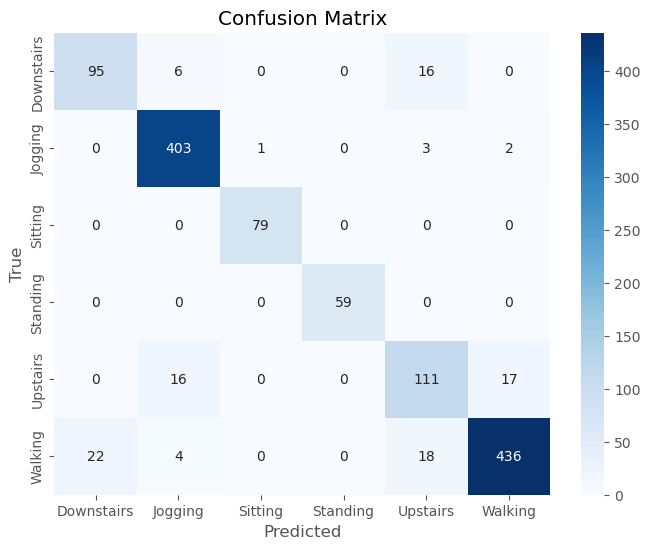

In [41]:
name = 'cnn-4-incrementkernel-64features-incrementingstride-NOmaxpool-lstm-2-dropout-Bidirectional-WITHPOOLINGLSTMMETHOD-15EPOCH-NO-NORMALIZATION-alpha= 0.005'
model = MyModel()
mean, scale = new_model_run(model, name, train_params=train_params, show_conf_matrix=True, normalize=normalize, alpha = alpha)

In [42]:
X_test_sitch = normalize_X(X_test, (mean, scale))
model.eval()
with torch.no_grad():
    out = model(X_test_sitch)
class_value, class_index = torch.max(out, 1)
out_pred = le.inverse_transform(class_index)

<BarContainer object of 6 artists>

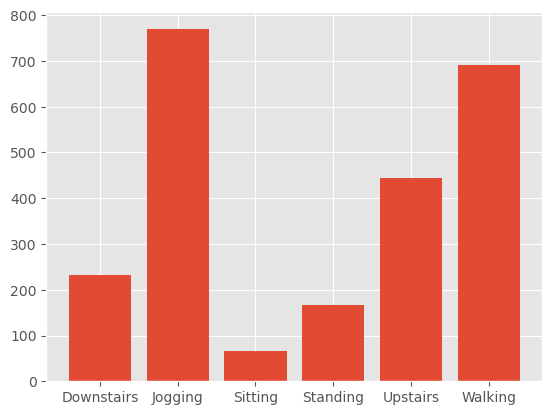

In [43]:
df = pd.DataFrame(data = {'p': out_pred})
plt.bar(le.classes_,df.groupby('p').size())

# Non-functional
The below code-blocks are included, but are not functional due to their deprecated references.

<BarContainer object of 6 artists>

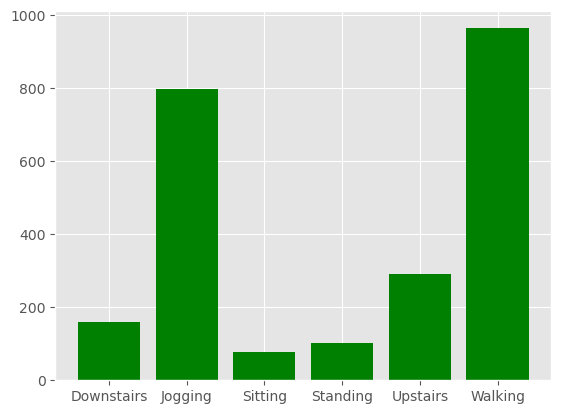

In [ ]:
df_randomforest = pd.read_csv('path/to/random_forest_prediction.csv')
plt.bar(le.classes_, df_randomforest.groupby('predicted').size(), color = 'g')

<BarContainer object of 6 artists>

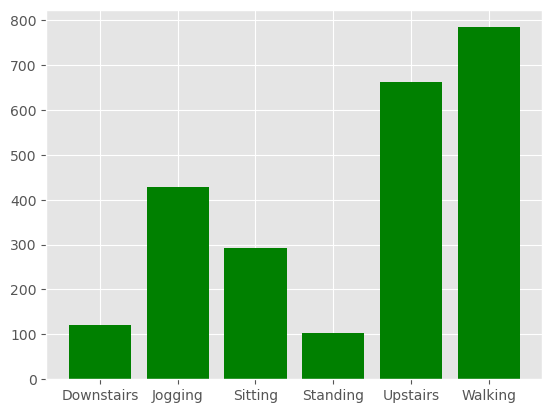

In [ ]:
df_deep = pd.read_csv('path/to/deep_model_predictions.csv')
plt.bar(le.classes_, df_deep.groupby('predicted').size(), color = 'g')

<BarContainer object of 6 artists>

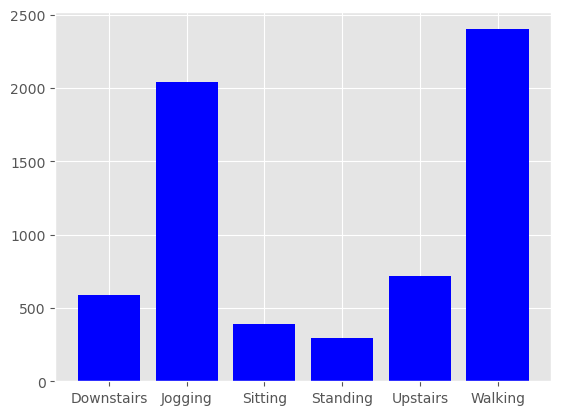

In [ ]:

plt.bar(le.classes_, df_train.groupby('activity').size(), color = 'b')

# Preparing Kaggle Submission file

In [ ]:
model.eval()

with torch.no_grad():
    _, predicted_class = torch.max(model(X_test), 1)

pd.concat([
    pd.DataFrame(data = {'id': df_test['id'], 'predicted': le.inverse_transform(predicted_class)}),
    pd.read_csv('../data/processed/predictions_allzero.csv')
]).to_csv('predictions/deep/' + name + '.csv', index = False)